<a href="https://colab.research.google.com/github/anazantoro/Trash-Classification-with-Convolutional-Neural-Network-/blob/main/V1_Notebook_Trash_Type_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the relevant libraries

In [1]:
import os
import io
import cv2
import random
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tensorflow.keras.preprocessing import image as keras_image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the dataset

In [3]:
DIR = "/content/drive/MyDrive/dataset/garbage_type_detection"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.2,
                                                                    subset="training", seed=42,
                                                                    batch_size=16)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.2,
                                                                  subset="validation", seed=42,
                                                                  batch_size=16)

Found 2568 files belonging to 6 classes.
Using 2055 files for training.
Found 2568 files belonging to 6 classes.
Using 513 files for validation.


In [4]:
def count_files_per_class(directory):
    class_counts = {}

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            class_counts[class_name] = len(files)

    return class_counts

file_counts = count_files_per_class(DIR)

for class_name, count in file_counts.items():
    print(f"Class '{class_name}' memiliki {count} file")

Class 'glass' memiliki 551 file
Class 'metal' memiliki 410 file
Class 'paper' memiliki 594 file
Class 'plastic' memiliki 482 file
Class 'cardboard' memiliki 403 file
Class 'trash' memiliki 128 file


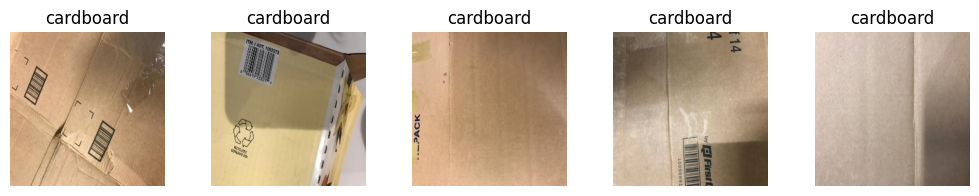

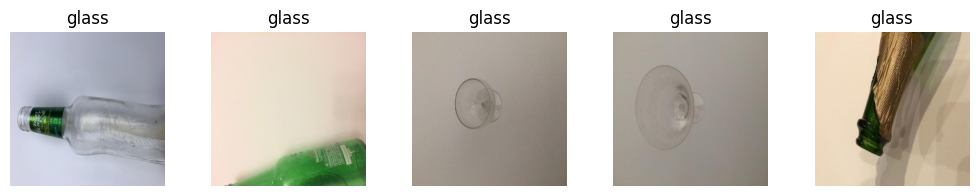

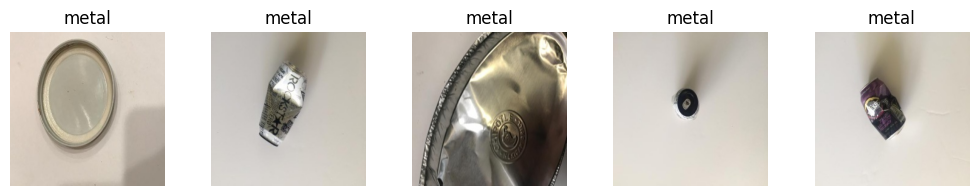

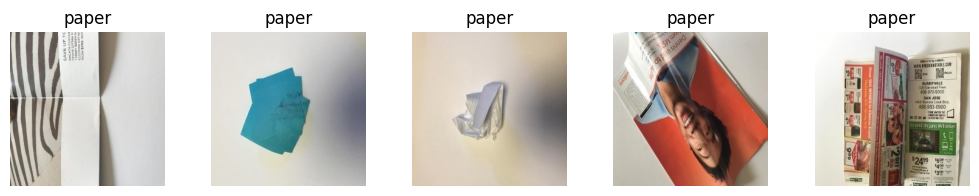

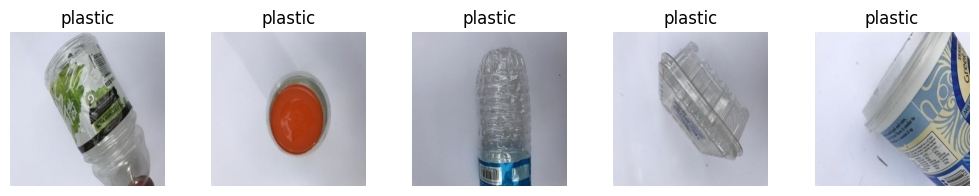

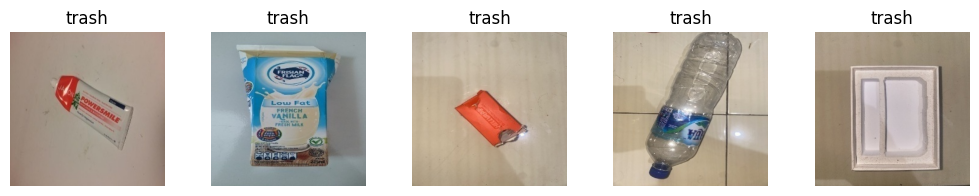

In [5]:
def plot_imgs(DIR, top=10):
    all_DIRs = os.listdir(DIR)
    item_files = [os.path.join(DIR, file) for file in all_DIRs][:5]

    plt.figure(figsize=(10, 10)) #pyplot

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(DIR))

plot_imgs(DIR+'/cardboard')
plot_imgs(DIR+'/glass')
plot_imgs(DIR+'/metal')
plot_imgs(DIR+'/paper')
plot_imgs(DIR+'/plastic')
plot_imgs(DIR+'/trash')

In [6]:
def plot_imgs(DIR, top=1):
    all_item_files = os.listdir(DIR)[:top]

    for idx, file in enumerate(all_item_files):
        img_path = os.path.join(DIR, file)
        img = cv2.imread(img_path)

        if img is not None:
            height, width = img.shape[:2]  # Mengambil dimensi gambar
            print(f"Image: {file}, Resolution: {width} x {height}")

plot_imgs(DIR)

plot_imgs(DIR+'/cardboard')
plot_imgs(DIR+'/glass')
plot_imgs(DIR+'/metal')
plot_imgs(DIR+'/paper')
plot_imgs(DIR+'/plastic')
plot_imgs(DIR+'/trash')

Image: cardboard_012.jpg, Resolution: 255 x 255
Image: glass_018.jpg, Resolution: 255 x 255
Image: metal_017.jpg, Resolution: 255 x 255
Image: paper_002.jpg, Resolution: 255 x 255
Image: plastic_027.jpg, Resolution: 255 x 255
Image: trash_120.jpg, Resolution: 255 x 255


In [7]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes, numClasses)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] 6


### Performing Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# MODELS

### ResNet152 Model

In [9]:
baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=numClasses)

for layers in baseModel.layers:
    layers.trainable=False

last_output = baseModel.layers[-1].output

x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

epochs=4
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.5397 - loss: 1.7238 - val_accuracy: 0.7836 - val_loss: 0.6483
Epoch 2/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.9160 - loss: 0.2469 - val_accuracy: 0.8246 - val_loss: 0.5715
Epoch 3/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9714 - loss: 0.0888 - val_accuracy: 0.8246 - val_loss: 0.5982
Epoch 4/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.9889 - loss: 0.0452 - val_accuracy: 0.8382 - val_loss: 0.6212


### Model Evaluation

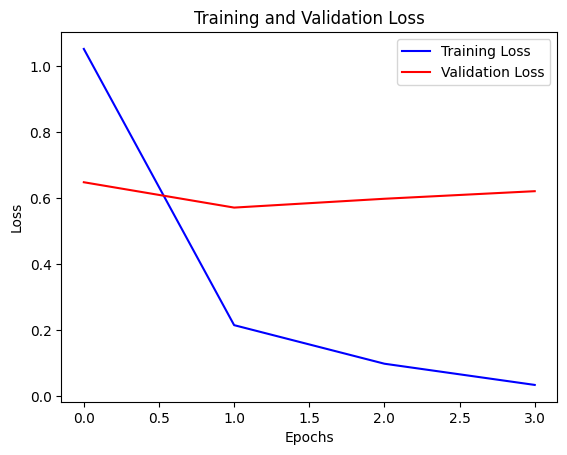

In [10]:
epochs = range(len(history.history["loss"]))

plt.plot(epochs, history.history["loss"], color="b", label="Training Loss")
plt.plot(epochs, history.history["val_loss"], color="r", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()


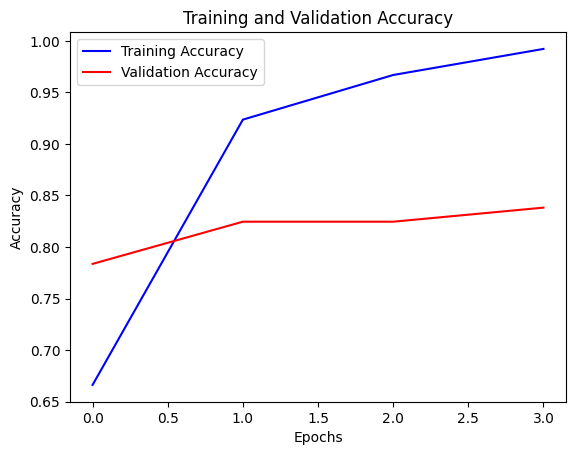

In [11]:
epochs = range(len(history.history["accuracy"]))

plt.plot(epochs, history.history["accuracy"], color="b", label="Training Accuracy")
plt.plot(epochs, history.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()


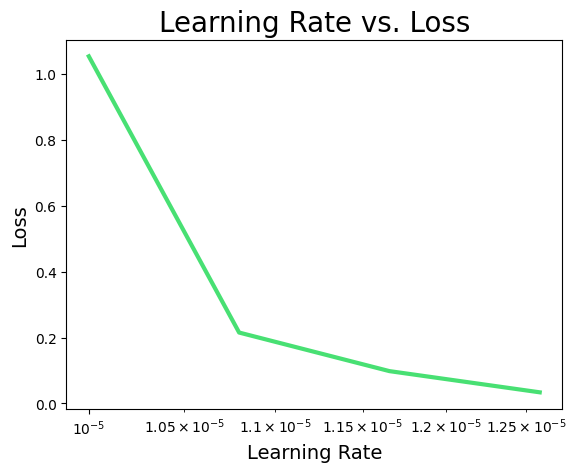

In [12]:
import numpy as np
import matplotlib.pyplot as plt

learning_rates = 1e-5 * (10 ** (np.arange(len(history.history['loss'])) / 30))

plt.plot(learning_rates, history.history
['loss'], lw=3, color='#48e073')
plt.xscale('log')
plt.title('Learning Rate vs. Loss', size=20)
plt.xlabel('Learning Rate', size=14)
plt.ylabel('Loss', size=14)
plt.show()


# Testing

### Dataset Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
[1.0000000e+02 6.8160450e-16 5.4592761e-11 1.8555487e-07 4.9261879e-11
 4.5857655e-09] 
 ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Prediction:  cardboard 100.0%


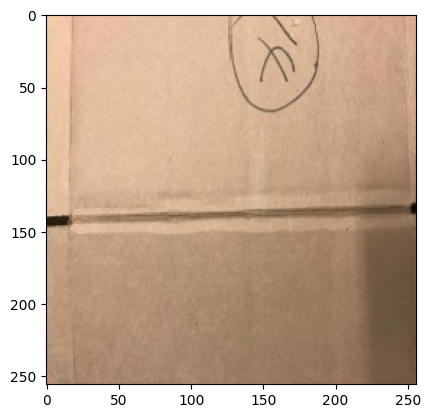

In [13]:
url = '/content/drive/MyDrive/dataset/garbage_type_detection'
image = tf.keras.utils.get_file("/content/drive/MyDrive/dataset/garbage_type_detection/cardboard/cardboard_001.jpg", origin=url)

img = tf.keras.preprocessing.image.load_img(image, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)

print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

### URL Testing


In [17]:
image_url = 'https://mycoffeeshop.com.au/cdn/shop/products/Duralex-Provence-latte-glass_1200x.png?v=1672098259'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


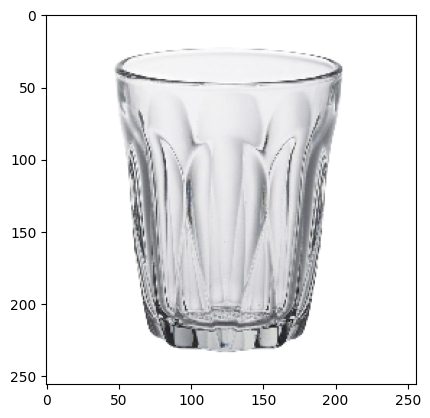

[2.2886506e-09 9.9999931e+01 2.5189953e-05 3.3182359e-06 4.7761067e-05
 1.3304377e-10] 
 ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Prediction:  glass 99.99992847442627%


In [18]:
def load_image_from_url(url, target_size=(256, 256)):
    session = requests.Session()
    retry = Retry(connect=5, backoff_factor=1)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)

    headers = {'User-Agent': 'Mozilla/5.0'}

    img_response = session.get(url, headers=headers)
    img_response.raise_for_status()

    img_bytes = io.BytesIO(img_response.content)
    img = keras_image.load_img(img_bytes, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array, img


try:
    img_array, img = load_image_from_url(image_url)
    predictions = model.predict(img_array)
    plt.imshow(img)
    plt.show()
    print(predictions[0] * 100, "\n", classes)
    print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")
except requests.exceptions.RequestException as e:
    print(f"Error fetching the image: {e}")

In [16]:
# model.save('model.h5')